# The Seattle Fire Department Problem



In [1]:
%%writefile train.py
from call_db.calls import callDB
from pop_predict.predict import populationPredictor
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import datetime as dt

Overwriting train.py


In [2]:
%%writefile -a train.py

def collect_data(call_db, first_date, last_date, categories=None):
    data = []

    delta = dt.timedelta(days=1)
    day = first_date

    while day <= last_date:
        details = call_db.get_date_details(day)
        weather = call_db.get_weather(day)
        covid = call_db.get_covid_info(day)
        weekend = 0
        holiday = 0
        snow = 0
    
        if details["weekday"] >= 5:
            weekend = 1
        if details["holiday"] > 0:
            holiday = 1
        if weather["SNOW"] > 0:
            snow = 1
            
        daily_data = {
            #"HOURLY_CALLS": details["hourly_stats"],
            "CALLS": details["calls"],
            "DAY": details["day"],
            "MONTH": details["month"],
            "YEAR": details["year"],        
            "HOLIDAY": details["holiday"],
            "WEEKEND_BOOL": weekend,
            "HOLIDAY_BOOL": holiday,
            "WEEKDAY": details["weekday"],
            "POP": details["population"],
            "DAY_YEAR": details["day_of_year"],
            "WINTER": details["Winter"],
            "SPRING": details["Spring"],
            "SUMMER": details["Summer"], 
            "FALL": details["Fall"],
            "TMIN": weather["TMIN"],
            "TMAX": weather["TMAX"],
            "TAVG": weather["TAVG"],
            "SNOW": weather["SNOW"],
            "SNOW_BOOL": snow,
            "PRCP": weather["PRCP"],
            "FOG": weather["WT01"],
            "HVY_FOG": weather["WT02"],
            "THUNDER": weather["WT03"],
            "ICE": weather["WT04"],
            "HAIL": weather["WT05"],
            "GLAZE": weather["WT06"],
            "HAZE": weather["WT08"],    
            "PCR_TESTS": covid["pcr_test"],
            "WEEKLY_PCR_TESTS": covid["seven_day_pcr_test"],
            "PCR_TESTS_POS": covid["pcr_pos"],
            "WEEKLY_PCR_TESTS_POS": covid["seven_day_pcr_pos"],
            "HOSP_CNT": covid["hosp_cnt"],
            "DEATH_CNT": covid["death_cnt"],
            "WEEKLY_HOSP_CNT": covid["seven_day_hosp_cnt"],
            "WEEKLY_DEATH_CNT": covid["seven_day_death_cnt"],
            "PANDEMIC": covid["pandemic"]
        }

        if categories != None:
            sum = 0
            cat_data = details["type_stats"]
            for cat in categories:
                if cat not in cat_data.keys():
                    daily_data.update({cat: 0})
                else:
                    daily_data.update({cat: cat_data[cat]})
                    sum += cat_data[cat]
            daily_data.update({"Misc Emergencies": (details["calls"] - sum)})
   
        data.append(daily_data)
        day += delta

    return(pd.DataFrame(data))

Appending to train.py


In [3]:
%run train.py

### Create the database
We first create a SQLite database of the emergency calls in Seattle using our callDB-module. 

You can download an up-to-date dataset of 911 calls in Seattle from https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkq or use the version provided with this project.

We will also include weather information in the database by specifying a file containing historic weather data of Seattle. More precisely, data from 2003-01-01 to 2024-01-11 23:59 of the weather station SEATTLE SAND POINT WEATHER FORECAST OFFICE, WA US
(GHCND:USW00094290). You can obtain data from different stations or different time periods from the webpage of the National Oceanic and Atmospheric Administration (NOAA) at https://www.ncei.noaa.gov/cdo-web/.

We further set the `rebuild` flag to `True` to overwrite possibly already existing databases and specify a beginning date for dates to be included in the database, `dmin="2010-01-01"`. Note that dates throughout this project are either a string of the format YYYY-MM-DD or a `date` object.

If you want to create a new database object and use an existing database file without changes you can set the `load_only` flag to `True`.



In [4]:
db = callDB("Seattle_Real_Time_Fire_911_Calls_20240111.csv", weather_data="weather_data.csv", covid_data= "COVID.csv", rebuild=True, dmin="2010-01-01")#, load_only=True)

## Feature selection
Before we start training our model, we first inspect the dataset to see which features have the biggest impact on the number of emergency calls.

We start by extracting the data as a `DataFrame` from our database using the `collect_data` function defined above. We use all the data until the 31. December 2022 as training data and leave the rest for test/validation of our model.

In [5]:
data = collect_data(db, db.first_date, dt.date(2022,12,31))
#data = collect_data(db, dt.date(2022,1,1), dt.date(2022,12,31))
#data = collect_data(db, db.first_date, db.last_date)
test_data = collect_data(db, dt.date(2023,1,1), db.last_date)
features = data.drop("CALLS", axis=1)

As a first check, we calculate the variance of the different features to check if any columns is constant and can therefore be dropped from the features list.

In [6]:
np.var(features)

DAY                     7.743642e+01
MONTH                   1.189310e+01
YEAR                    1.399789e+01
HOLIDAY                 1.773393e+00
WEEKEND_BOOL            2.041203e-01
HOLIDAY_BOOL            3.059418e-02
WEEKDAY                 3.999368e+00
POP                     1.807158e+10
DAY_YEAR                1.111613e+04
WINTER                  1.860170e-01
SPRING                  1.884442e-01
SUMMER                  1.884442e-01
FALL                    1.870781e-01
TMIN                    2.516594e+01
TMAX                    5.032327e+01
TAVG                    3.532903e+00
SNOW                    1.730735e+01
SNOW_BOOL               9.181181e-03
PRCP                    3.530635e+01
FOG                     1.130626e-01
HVY_FOG                 8.974426e-03
THUNDER                 1.021363e-02
ICE                     1.472131e-03
HAIL                    1.051966e-03
GLAZE                   2.105706e-04
HAZE                    1.452569e-02
PCR_TESTS               3.313154e+06
W

It turns out that no column is constant but the `GLAZE` column has extremely low variance.

### Mutual Information
We now calculate the mutual information of the features with our target variable, the number of emergency calls.

In [7]:
info = mutual_info_classif(features, data["CALLS"])
list(zip(features.columns, info))

[('DAY', 0.0),
 ('MONTH', 0.03869762607344196),
 ('YEAR', 0.45574195280761387),
 ('HOLIDAY', 0.014950739322967088),
 ('WEEKEND_BOOL', 0.003144038111885905),
 ('HOLIDAY_BOOL', 0.0),
 ('WEEKDAY', 0.032812292258403986),
 ('POP', 0.4597739489295991),
 ('DAY_YEAR', 0.0271385946894247),
 ('WINTER', 0.029282237619443485),
 ('SPRING', 0.001090815794402289),
 ('SUMMER', 0.04264860108404278),
 ('FALL', 0.0021934855430743028),
 ('TMIN', 0.05768493114666917),
 ('TMAX', 0.06733595271790449),
 ('TAVG', 0.051292928640084945),
 ('SNOW', 0.0),
 ('SNOW_BOOL', 0.004404038477496819),
 ('PRCP', 0.01713432582726515),
 ('FOG', 0.023291217091169436),
 ('HVY_FOG', 0.0),
 ('THUNDER', 4.68597020359951e-05),
 ('ICE', 0.0),
 ('HAIL', 0.0),
 ('GLAZE', 0.013706184508429864),
 ('HAZE', 0.0025185430261513986),
 ('PCR_TESTS', 0.06787440272191336),
 ('WEEKLY_PCR_TESTS', 0.0941915228868151),
 ('PCR_TESTS_POS', 0.08422670038612168),
 ('WEEKLY_PCR_TESTS_POS', 0.10814507691312603),
 ('HOSP_CNT', 0.0631220834246653),
 ('DEAT

#### Plotting the mutual information
For a better oversight we plot the mutual information with a threshold line at 0.025.

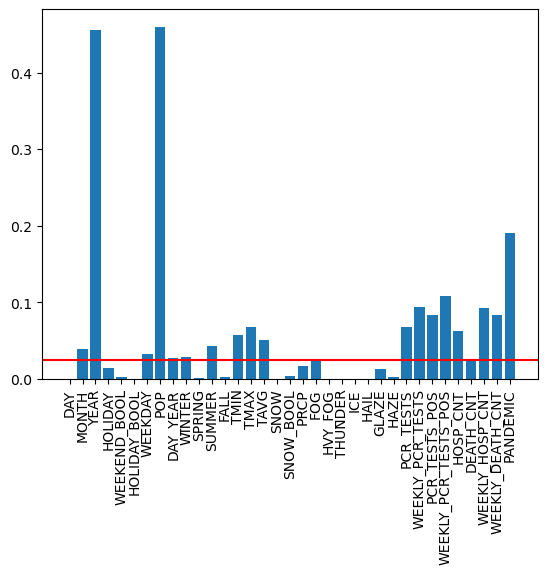

In [8]:
import matplotlib.pyplot as plt
plt.bar(range(len(info)), info)
plt.axhline(y=0.025, color='r', linestyle='-')
_ = plt.xticks(range(len(info)), features.columns, rotation=90)

#### Summary
Clearly, the `YEAR` and `POP` features have the highest mutual information with the number of emergency calls. However, both are obviously strongly correlated and we should only include one of the two features in our model. The same holds for the three temperature variables `TMIN`, `TMAX` and `TAVG`. Clearly, the numbers related to the COVID19 pandemic have a very high mutual information. With one notable exception, `DEATH_CNT`.

### ANOVA analysis
Next we use ANOVA to analyze the correlation between the different features and the number of emergency calls.

In [9]:
ANOVA = f_classif(features, data["CALLS"])

/usr/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


The `GLAZE` column leads to a `RuntimeWarning` which we decide to ignore for the moment. To avoid this warning we could `drop` the `GLAZE` line from our `features` dataframe.

In [10]:
ANOVA_df = pd.DataFrame({"feature": features.columns, "F-Score": list(ANOVA[0]), "p-value": list(ANOVA[1])})
ANOVA_df.sort_values(by="p-value")

,feature,F-Score,p-value
2,YEAR,15.499743,0.000000e+00
24,GLAZE,inf,0.000000e+00
7,POP,15.882276,0.000000e+00
28,PCR_TESTS_POS,6.271698,1.164503e-152
29,WEEKLY_PCR_TESTS_POS,5.357159,4.259750e-122
34,PANDEMIC,4.770380,1.793974e-102
30,HOSP_CNT,4.361911,6.966918e-89
32,WEEKLY_HOSP_CNT,4.298838,8.544245e-87
17,SNOW_BOOL,3.918355,2.816320e-74
14,TMAX,3.586295,1.648470e-63


#### Summary
On the first glimpse the results of both methods is similar. The ANOVA analysis confirms the strong impact of the `YEAR` and `POP` variables. However, we also obtain relatively small p-values for the `SNOW`, `WEEKEND_BOOL` and `HAIL` variables. Furthermore, the `SUMMER` variable seems to have a much higher impact on the result than the other seasonal variables.

### Conclusion
Based on this analysis, we decide to include the following features in the training of our model:


In [11]:
relevant_features = ["POP", "PRCP", "MONTH", "TMAX", "SNOW_BOOL", "SUMMER", "WINTER", "PRCP", "HAZE", "HAIL", "WEEKEND_BOOL", "HOLIDAY_BOOL", "WEEKLY_HOSP_CNT", "WEEKLY_DEATH_CNT", "WEEKLY_PCR_TESTS", "WEEKLY_PCR_TESTS_POS", "PANDEMIC"]
data[relevant_features]

,POP,PRCP,MONTH,TMAX,SNOW_BOOL,SUMMER,WINTER,PRCP,HAZE,HAIL,WEEKEND_BOOL,HOLIDAY_BOOL,WEEKLY_HOSP_CNT,WEEKLY_DEATH_CNT,WEEKLY_PCR_TESTS,WEEKLY_PCR_TESTS_POS,PANDEMIC
0,3069000,9.1,1,11.1,0,0,1,9.1,0.0,0.0,0,1,0,0,0,0,0
1,3069000,0.8,1,10.0,0,0,1,0.8,0.0,0.0,1,0,0,0,0,0,0
2,3069000,0.5,1,8.9,0,0,1,0.5,0.0,0.0,1,0,0,0,0,0,0
3,3069000,18.0,1,8.9,0,0,1,18.0,0.0,0.0,0,0,0,0,0,0,0
4,3069000,1.8,1,8.9,0,0,1,1.8,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,3489000,20.6,12,11.7,0,0,1,20.6,0.0,0.0,0,0,23,3,5372,437,1
4744,3489000,0.3,12,8.3,0,0,1,0.3,0.0,0.0,0,0,22,3,5289,439,1
4745,3489000,7.9,12,7.8,0,0,1,7.9,0.0,0.0,0,0,24,2,5182,422,1
4746,3489000,7.6,12,11.1,0,0,1,7.6,0.0,0.0,0,0,24,2,5627,455,1


## Training the model I

We compare two very similar models, the *Gradient Boosting Regressor* and the *Histogram Gradient Boosting Regressor* from the Scikit-Learn library. We use the 13 years of data from 2010-01-01 to 2022-12-31 as training data and the data from 2023-01-01 to the end as test data.

### Preparing training and test data

In [12]:
training_X = data[relevant_features]
training_y = data["CALLS"]

test_X = test_data[relevant_features]
test_y = test_data["CALLS"]

### Train the HistGradientBoostingRegressor

In [13]:
hist_model = HistGradientBoostingRegressor(#categorical_features=categorical_features,
                                      max_iter=1500,
                                      max_leaf_nodes=500,
                                      max_bins=255,
                                      ).fit(training_X, training_y)

### Train the GradientBoostingRegressor

In [14]:
model = GradientBoostingRegressor(n_estimators=250,
                                    learning_rate = 0.2,
                                    subsample = 0.75).fit(training_X, training_y)

### Scoring the predictions
We use the model specific scoring function to get a measure for the goodness of our estimators. In this case the metric is the $R^2$ or coefficient of determination regression score function.

In [15]:
print(hist_model.score(test_X,test_y))
print(model.score(test_X,test_y))

-0.38952858213765706
-2.012489165340356


### Conclusion
Unfortunately, both estimators perform terribly. One reason might be that our test set consists basically of post-pandemic numbers whereas the whole COVID19 or at least the time where the pandemic had a heavy influence on 911 calls is part of our training set. This effect could not be mitigated by including COVID numbers in our training features. As a remedy we will try to obtain better results by splitting the whole data randomly into a training and a test set.

## Training the model II
We now use the `train_test_split` function to split the data into a training and a test set.

In [16]:
full_data = collect_data(db, db.first_date, db.last_date)
rand_training_X, rand_test_X, rand_training_y, rand_test_y = train_test_split(full_data[relevant_features], full_data["CALLS"], random_state=42, test_size=0.25) 

### Train the HistGradientBoostingRegressor

In [17]:
hist_model_2 = HistGradientBoostingRegressor(#categorical_features=categorical_features,
                                      max_iter=1500,
                                      max_leaf_nodes=500,
                                      max_bins=255,
                                      ).fit(rand_training_X, rand_training_y)

### Train the GradientBoostingRegressor

In [18]:
model_2 = GradientBoostingRegressor(n_estimators=250,
                                    learning_rate = 0.2,
                                    subsample = 0.75).fit(rand_training_X, rand_training_y)

In [19]:
print(f"R2-score of the HistGradientBoostingRegressor is: {hist_model_2.score(rand_test_X,rand_test_y)}")
print(f"R2-score of the GradientBoostingRegressor is: {model_2.score(rand_test_X,rand_test_y)}")

R2-score of the HistGradientBoostingRegressor is: 0.6059300567683955
R2-score of the GradientBoostingRegressor is: 0.7168431764963573


### Conclusion
Randomizing the training data seems to have worked, the $R^2$-score of the *GradientBoostingRegressor* is approximately 0.723. We can calculate the standard deviation of our estimator:

In [20]:
predict_calls = model_2.predict(rand_test_X)
delta = rand_test_y - predict_calls
delta_percent = delta/rand_test_y * 100
mse = np.var(delta)
print(f"The standard deviation of the GradientBoostingRegressor is {np.sqrt(mse)}.")

The standard deviation of the GradientBoostingRegressor is 24.258752646042357.


In [21]:
np.mean(rand_test_y)

267.8298204527713

## Write to file
We use the GradientBoostingRegressor from above to implement a `calls_estimator` function and write it to the test.py file.

In [22]:
%%writefile -a train.py

def calls_estimator(relevant_features):
    full_data = collect_data(db, db.first_date, db.last_date)
    rand_training_X, rand_test_X, rand_training_y, rand_test_y = train_test_split(full_data[relevant_features], full_data["CALLS"], random_state=42, test_size=0.25)
    model = GradientBoostingRegressor(n_estimators=250,
                                    learning_rate = 0.2,
                                    subsample = 0.75).fit(rand_training_X, rand_training_y)
    return(model)

Appending to train.py


In [23]:
%%writefile -a train.py

if __name__ == "__main__":
    db = callDB("Seattle_Real_Time_Fire_911_Calls_20240111.csv", weather_data="weather_data.csv", covid_data= "COVID.csv", rebuild=True, dmin="2010-01-01", load_only=True)
    relevant_features = ["POP", "PRCP", "MONTH", "TMAX", "SNOW_BOOL", "SUMMER", "WINTER", "HAZE", "HAIL", "WEEKEND_BOOL", "HOLIDAY_BOOL", "WEEKLY_HOSP_CNT", "WEEKLY_DEATH_CNT", "WEEKLY_PCR_TESTS", "WEEKLY_PCR_TESTS_POS", "PANDEMIC"]
    model = calls_estimator(relevant_features)
    date_str = input("Please enter the date for which the 911-Calls should be predicted. Use the format YYYY-MM-DD.")
    weather = input(f"Do you have weather information for {date_str}? y/N")
    if weather in ["y","yes", "Y", "YES", "Yes"]:
        PRCP = input(f"WEATHER: Enter the amount of precipitation for {date_str}. Press ENTER to skip.")
        if PRCP == "":
            PRCP = 0
        TMAX = input(f"WEATHER: Enter the maximal temperature (in degrees Celsius) for {date_str}. Press ENTER to skip.")
        if TMAX == "":
            TMAX = 18
        SNOW_BOOL = input(f"WEATHER: Is it going to snow on {date_str}? Enter 0 for No and 1 for Yes. Press ENTER to skip.")
        if SNOW_BOOL == "":
            SNOW_BOOL = 0
        HAZE = input(f"WEATHER: Is it going to be hazy on {date_str}? Enter 0 for No and 1 for Yes. Press ENTER to skip.")
        if HAZE == "":
            HAZE = 0        
        HAIL = input(f"WEATHER: Is hail expected on {date_str}? Enter 0 for No and 1 for Yes. Press ENTER to skip.")
        if HAIL == "":
            HAIL = 0
    else:
        PRCP = 0
        TMAX = 18
        SNOW_BOOL = 0
        HAZE = 0
        HAIL = 0
    covid = input(f"Do you have covid information for {date_str}? y/N")
    if covid in ["y","yes", "Y", "YES", "Yes"]:
        WEEKLY_HOSP_CNT = input("How many people were hospitalized within the past seven days with COVID? Press ENTER to skip.")
        if WEEKLY_HOSP_CNT == "":
            WEEKLY_HOSP_CNT = 0
        WEEKLY_DEATH_CNT = input("How many people died within the past seven days from COVID? Press ENTER to skip.")
        if WEEKLY_DEATH_CNT == "":
            WEEKLY_DEATH_CNT = 0
        WEEKLY_PCR_TESTS = input("How many PCR tests were registered within the last 7 days? Press ENTER to skip.")
        if WEEKLY_PCR_TESTS == "":
            WEEKLY_PCR_TESTS = 0
        WEEKLY_PCR_TESTS_POS = input("How many positive PCR tests were registered within the last 7 days? Press ENTER to skip.")
        if WEEKLY_PCR_TESTS_POS == "":
            WEEKLY_PCR_TESTS_POS = 0
    else:
        WEEKLY_HOSP_CNT = 0
        WEEKLY_DEATH_CNT = 0
        WEEKLY_PCR_TESTS = 0
        WEEKLY_PCR_TESTS_POS = 0

    pop = populationPredictor()

    date = dt.datetime.strptime(date_str, "%Y-%m-%d").date()

    weekend = 0
    if date.weekday() in [5,6]:
        weekend = 1

    holiday = 0
    if date in db.wa_holidays:
        holiday = 1

    pandemic_start = dt.date(2020,1,30)
    pandemic_end = dt.date(2023,5,5)

    pandemic = 0
    
    if date > pandemic_start and date < pandemic_end:
        pandemic = 1
    

    details = [{"POP": pop.predict(date.year),
               "PRCP": PRCP,
               "MONTH": date.month,
               "TMAX": TMAX,
               "SNOW_BOOL": SNOW_BOOL,
               "SUMMER": db.get_season(date)["Summer"],
               "WINTER": db.get_season(date)["Winter"],
               "HAZE": HAZE,
               "HAIL": HAIL,
               "WEEKEND_BOOL": weekend,
               "HOLIDAY_BOOL": holiday,
               "WEEKLY_HOSP_CNT": WEEKLY_HOSP_CNT,
               "WEEKLY_DEATH_CNT": WEEKLY_DEATH_CNT,
               "WEEKLY_PCR_TESTS": WEEKLY_PCR_TESTS,
               "WEEKLY_PCR_TESTS_POS": WEEKLY_PCR_TESTS_POS,
               "PANDEMIC": pandemic},]

    calls_prediction = model.predict(pd.DataFrame(details))

    print(f"For {date_str} a total of {calls_prediction[0]} Emergency calls is predicted. The standard deviation of this estimator is less than 25 calls.")
               
               
    

Appending to train.py


In [24]:
%run train.py

Please enter the date for which the 911-Calls should be predicted. Use the format YYYY-MM-DD. 2024-04-06
Do you have weather information for 2024-04-06? y/N 
Do you have covid information for 2024-04-06? y/N 


For 2024-04-06 a total of 324.4109817688517 Emergency calls is predicted. The standard deviation of this estimator is less than 25 calls.


## Outlook
We have already all features implemented to create estimators for each category of emergency calls individually. This might lead to better overall predictions as different categories will depend on different features. First, we list the *important categories*. That is, those categories with more than 5000 calls.

In [25]:
call_categories = db.get_type_stats(start_ts=db.first_timestamp, end_ts=db.last_timestamp)
important_categories = [cat for cat in call_categories.keys() if call_categories[cat] > 5000]
important_categories

['Aid Response',
 'Auto Fire Alarm',
 'Triaged Incident',
 'Medic Response',
 'Rescue Elevator',
 'Investigate Out Of Service',
 'Medic Response- 7 per Rule',
 'Automatic Fire Alarm Resd',
 'Automatic Medical Alarm',
 'AFA4 - Auto Alarm 2 + 1 + 1',
 'Aid Response Yellow',
 '1RED 1 Unit',
 'Illegal Burn',
 'Low Acuity Response',
 'Trans to AMR',
 'Alarm Bell',
 'MVI - Motor Vehicle Incident',
 'Automatic Fire Alarm False',
 'Activated CO Detector',
 'Nurseline/AMR',
 'EVENT - Special Event',
 '4RED - 2 + 1 + 1',
 'Rubbish Fire',
 'Motor Vehicle Accident',
 'Medic Response, 7 per Rule',
 'Medic Response, 6 per Rule']

### Collect data with different categories
We can pass our `important_categories` to the `collect_data` function to get the data with numbers of calls per category.

In [26]:
cat_data = collect_data(db, db.first_date, db.last_date, important_categories)
cat_features = cat_data.drop(important_categories + ["CALLS", "Misc Emergencies"], axis=1)

### Select one category of calls


In [27]:
category = 'Auto Fire Alarm'

### Analyze the data
As before, we analyze the data to determine the relevant features for predicting the number of calls.

In [28]:
info = mutual_info_classif(cat_features, cat_data[category])
list(zip(features.columns, info))

[('DAY', 0.0029528886243941344),
 ('MONTH', 0.02299385429807943),
 ('YEAR', 0.09869017564820126),
 ('HOLIDAY', 0.0033269442085290812),
 ('WEEKEND_BOOL', 0.023518491444565193),
 ('HOLIDAY_BOOL', 0.0),
 ('WEEKDAY', 0.033190785179125104),
 ('POP', 0.09534692419950996),
 ('DAY_YEAR', 0.028816472257255477),
 ('WINTER', 0.0),
 ('SPRING', 0.009034997226372354),
 ('SUMMER', 0.012696412127178647),
 ('FALL', 0.0),
 ('TMIN', 0.005543685031940804),
 ('TMAX', 0.005779318806704126),
 ('TAVG', 0.0),
 ('SNOW', 0.017625585829814217),
 ('SNOW_BOOL', 0.004774042007988033),
 ('PRCP', 0.01745909381374977),
 ('FOG', 0.0027716521531835348),
 ('HVY_FOG', 0.0),
 ('THUNDER', 0.0009267823107323991),
 ('ICE', 0.0002760549520348654),
 ('HAIL', 0.0),
 ('GLAZE', 0.011766250054096261),
 ('HAZE', 0.005225351815052903),
 ('PCR_TESTS', 0.014602870223085151),
 ('WEEKLY_PCR_TESTS', 0.03791823259041349),
 ('PCR_TESTS_POS', 0.024345005207601744),
 ('WEEKLY_PCR_TESTS_POS', 0.04589535938940292),
 ('HOSP_CNT', 0.03548584783952

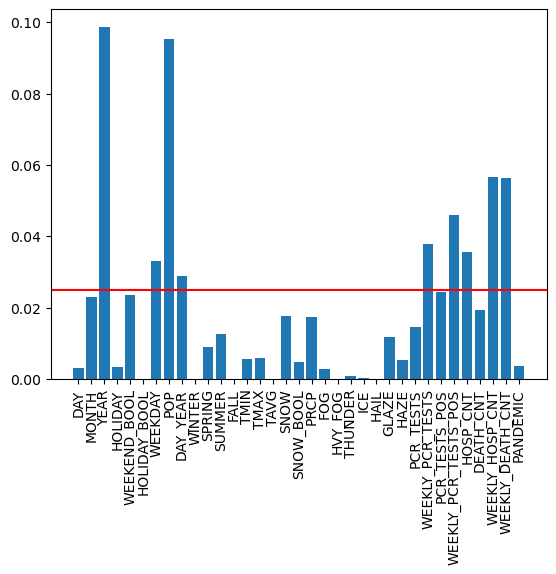

In [29]:
plt.bar(range(len(info)), info)
plt.axhline(y=0.025, color='r', linestyle='-')
_ = plt.xticks(range(len(info)), cat_features.columns, rotation=90)

In [30]:
ANOVA = f_classif(cat_features, cat_data[category])
ANOVA_df = pd.DataFrame({"feature": cat_features.columns, "F-Score": list(ANOVA[0]), "p-value": list(ANOVA[1])})
ANOVA_df.sort_values(by="p-value")

/usr/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,feature,F-Score,p-value
24,GLAZE,inf,0.000000e+00
2,YEAR,13.384086,3.078410e-94
7,POP,11.980711,1.306829e-82
32,WEEKLY_HOSP_CNT,7.531281,7.883239e-46
4,WEEKEND_BOOL,6.931209,6.067097e-41
17,SNOW_BOOL,6.591237,3.416692e-38
30,HOSP_CNT,6.313628,5.863887e-36
28,PCR_TESTS_POS,6.203879,4.450508e-35
34,PANDEMIC,5.223600,2.573329e-27
29,WEEKLY_PCR_TESTS_POS,4.731942,1.643787e-23


### Choose relevant features

In [31]:
relevant_features = ["POP", "PANDEMIC", "WEEKLY_HOSP_CNT", "PRCP", "WEEKLY_PCR_TESTS", "WEEKLY_PCR_TESTS_POS", "WEEKEND_BOOL", "WEEKDAY", "HOLIDAY", "MONTH"]

### Prepare training and testing data

In [32]:
rand_cat_training_X, rand_cat_test_X, rand_cat_training_y, rand_cat_test_y = train_test_split(cat_data[relevant_features], cat_data[category], random_state=42, test_size=0.25) 

### Train the model

In [33]:
model_3 = GradientBoostingRegressor(n_estimators=250,
                                    learning_rate = 0.2,
                                    subsample = 0.75).fit(rand_cat_training_X, rand_cat_training_y)

In [34]:
print(f"R2-score of the GradientBoostingRegressor is: {model_3.score(rand_cat_test_X,rand_cat_test_y)}")

R2-score of the GradientBoostingRegressor is: 0.19220087499556548


In [35]:
predict_cat_calls = model_3.predict(rand_cat_test_X)
delta = rand_cat_test_y - predict_cat_calls
delta_percent = delta/rand_cat_test_y * 100
mse = np.var(delta)
print(f"The standard deviation of the GradientBoostingRegressor is {np.sqrt(mse)}.")

The standard deviation of the GradientBoostingRegressor is 4.98879945931981.


In [36]:
np.mean(rand_cat_test_y)

14.321623731459797